In [7]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris
import random
import numpy as np
import pandas as pd
from sklearn.utils import Bunch
import seaborn as sns
import matplotlib.pyplot as plt


In [8]:
class MLP:
    def __init__(
        self,
        num_entrada,
        num_neuronio_oculto,
        num_classe,
        taxa_aprendizado=0.1,
        epocas=1000,
    ):
        self.num_entrada = num_entrada
        self.num_neuronio_oculto = num_neuronio_oculto
        self.num_classe = num_classe
        self.taxa_aprendizado = taxa_aprendizado
        self.epocas = epocas

        self.pesos_ocultos = np.random.uniform(0, 1, (num_entrada, num_neuronio_oculto))
        self.bias_oculto = np.zeros((1, num_neuronio_oculto))
        self.pesos_saida = np.random.uniform(0, 1, (num_neuronio_oculto, num_classe))
        self.bias_saida = np.zeros((1, num_classe))
        print(
            "num_entrada: ",
            self.num_entrada,
            "num_neuronio_oculto: ",
            self.num_neuronio_oculto,
            "num_classe: ",
            self.num_classe,
            "taxa_aprendizado: ",
            self.taxa_aprendizado,
            "epocas: ",
            self.epocas,
        )
        # print("\npesos_ocultos:\n ", self.pesos_ocultos, "\nbias_oculto:\n ", self.bias_oculto,
        #      "\npesos_saida:\n ", self.pesos_saida, "\nbias_saida:\n ", self.bias_saida)

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def forward(self, X):
        ativacao_oculta = np.dot(X, self.pesos_ocultos)
        ativacao_oculta += self.bias_oculto
        saida_oculta = self.sigmoid(ativacao_oculta)

        ativacao_saida = np.dot(saida_oculta, self.pesos_saida)
        ativacao_saida += self.bias_saida
        saida = self.sigmoid(ativacao_saida)

        return saida_oculta, saida

    def backward(self, X, y, saida_oculta, saida):
        # print("saida_oculta: ",saida_oculta)
        erro_saida = y - saida
        delta_saida = erro_saida * (saida * (1 - saida) + 0.05)
        # print("delta_saida: ",delta_saida)

        erro_oculto = np.dot(delta_saida, self.pesos_saida.T)
        delta_oculto = erro_oculto * (saida_oculta * (1 - saida_oculta) + 0.05)

        self.pesos_saida += np.dot(saida_oculta.T, delta_saida) * self.taxa_aprendizado
        self.bias_saida += (
            np.sum(delta_saida, axis=0, keepdims=True) * self.taxa_aprendizado
        )

        self.pesos_ocultos += np.dot(X.T, delta_oculto) * self.taxa_aprendizado
        self.bias_oculto += (
            np.sum(delta_oculto, axis=0, keepdims=True) * self.taxa_aprendizado
        )

    def treinar(self, X, y):
        self.pesos_ocultos = np.random.randn(self.num_entrada, self.num_neuronio_oculto)
        self.bias_oculto = np.zeros((1, self.num_neuronio_oculto))
        self.pesos_saida = np.random.randn(self.num_neuronio_oculto, self.num_classe)
        self.bias_saida = np.zeros((1, self.num_classe))
        for i in range(self.epocas):
            saida_oculta, saida = self.forward(X)
            self.backward(X, y, saida_oculta, saida)

    def testar(self, X, y):
        n_amostras = X.shape[0]
        erros_quadraticos = []
        matriz_confusao = None
        num_predicoes_corretas = 0

        saida_oculta, saida = self.forward(X)

        rotulos_previstos = np.argmax(saida, axis=1)
        rotulos_verdadeiros = np.argmax(y, axis=1)

        # calcular acurácia e erro médio quadrático
        for i in range(n_amostras):
            erros_quadraticos.append(
                sum(
                    [
                        (y[i][k] - (1 if k == rotulos_previstos[i] else 0)) ** 2
                        for k in range(self.num_classe)
                    ]
                )
            )
            if rotulos_previstos[i] == rotulos_verdadeiros[i]:
                num_predicoes_corretas += 1

        acuracia = num_predicoes_corretas / n_amostras
        std_acuracia = np.sqrt(acuracia * (1 - acuracia) / n_amostras)
        erro_medio_quadratico = np.mean(erros_quadraticos)

        # calcular matriz de confusão
        rotulos_classes = list(set(rotulos_verdadeiros))
        n_classes = len(rotulos_classes)
        matriz_confusao = [[0 for i in range(n_classes)] for j in range(n_classes)]

        for i in range(n_amostras):
            rotulo_previsto = rotulos_previstos[i]
            rotulo_verdadeiro = rotulos_classes.index(rotulos_verdadeiros[i])
            matriz_confusao[rotulo_verdadeiro][rotulo_previsto] += 1

        return acuracia, std_acuracia, matriz_confusao, erro_medio_quadratico

    def rodar_independentes(self, X, y, n_rodadas):
        acuracias_t = []
        std_acuracias_t = []
        matrizes_confusao_t = np.zeros((self.num_classe, self.num_classe))
        erros_quadraticos_t = []

        acuracias = []
        std_acuracias = []
        matrizes_confusao = np.zeros((self.num_classe, self.num_classe))
        erros_quadraticos = []

        for i in range(n_rodadas):
            # separa as amostra 80,20
            y_treino_one_hot = np.eye(self.num_classe)[y]

            X_treino, X_teste, y_treino, y_teste = train_test_split(
                X, y_treino_one_hot, test_size=0.2
            )
            # print("\n\n", y_teste[1])
            self.treinar(X_treino, y_treino)

            (
                acuracia_t,
                std_acuracia_t,
                matriz_confusao_t,
                erro_medio_quadratico_t,
            ) = self.testar(X_treino, y_treino)
            acuracias_t.append(acuracia_t)
            std_acuracias_t.append(std_acuracia_t)
            matrizes_confusao_t += matriz_confusao_t
            erros_quadraticos_t.append(erro_medio_quadratico_t)

            (
                acuracia,
                std_acuracia,
                matriz_confusao,
                erro_medio_quadratico,
            ) = self.testar(X_teste, y_teste)
            acuracias.append(acuracia)
            std_acuracias.append(std_acuracia)
            matrizes_confusao += matriz_confusao
            erros_quadraticos.append(erro_medio_quadratico)
        # print("bias_oculto: ",self.bias_oculto)
        return (
            acuracias,
            std_acuracias,
            matrizes_confusao,
            erros_quadraticos,
            acuracias_t,
            std_acuracias_t,
            matrizes_confusao_t,
            erros_quadraticos_t,
        )


In [9]:
# normaliza
def normaliza(datas):
    nomes_coluna = [
        coluna for coluna in datas.columns if coluna != "target" and coluna != "bias"
    ]
    for coluna in nomes_coluna:
        min_value = datas[coluna].min()
        max_value = datas[coluna].max()
        datas[coluna] = (datas[coluna] - min_value) / (max_value - min_value)
    return pd.DataFrame(datas)


num_entrada:  6 num_neuronio_oculto:  5 num_classe:  3 taxa_aprendizado:  0.05 epocas:  2000

----------------treino-----------------

Acurácia = 87.40%, Erro Médio Quadrático = 0.25 , DP: 2.10%
[[1758.   26.  618.]
 [  68. 5749.  171.]
 [ 564.  116. 3330.]]

-----------------teste---------------

Acurácia = 85.52%, Erro Médio Quadrático = 0.29 , DP: 4.41%
[[ 411.    6.  181.]
 [  18. 1427.   67.]
 [ 137.   40.  813.]]


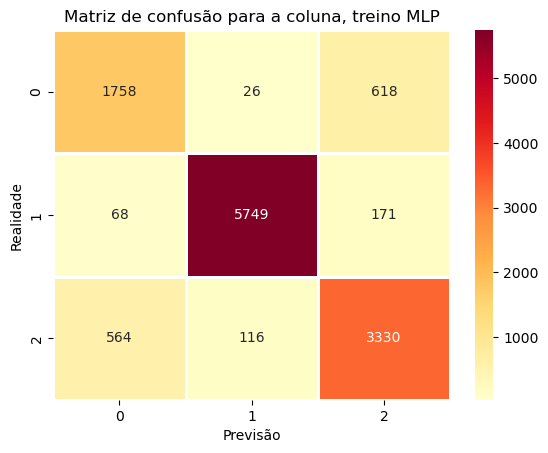

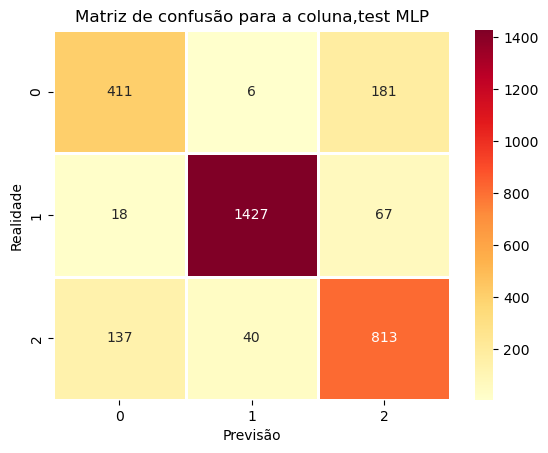

In [11]:
# coluna
coluna = pd.read_csv("Coluna/column_3C_weka.arff", header=None, sep=",")
coluna.columns = [
    "pelvic_incidence",
    "pelvic_tilt",
    "lumbar_lordosis_angle",
    "sacral_slope",
    "pelvic_radius",
    "degree_spondylolisthesis",
    "target",
]
coluna["target"].replace(to_replace="Hernia", value=0, inplace=True)
coluna["target"].replace(to_replace="Spondylolisthesis", value=1, inplace=True)
coluna["target"].replace(to_replace="Normal", value=2, inplace=True)
coluna2 = pd.DataFrame(coluna)
coluna = normaliza(coluna)
X1 = coluna.drop(["target"], axis=1)
y1 = coluna["target"]
# print(X1)
# print(y1)
# criar instância da classe MLP2 e treinar/testar com 10 rodadas independentes
mlp2 = MLP(
    num_entrada=6,
    num_neuronio_oculto=5,
    num_classe=3,
    taxa_aprendizado=0.05,
    epocas=2000,
)
(
    acuracias,
    std_acuracias,
    matrizes_confusao,
    erros_quadraticos,
    acuracias_t,
    std_acuracias_t,
    matrizes_confusao_t,
    erros_quadraticos_t,
) = mlp2.rodar_independentes(X1, y1, n_rodadas=50)

# imprimir resultados das 10 rodadas
print("\n----------------treino-----------------\n")
# for i in range(len(acuracias_t)):
# print(f"Rodada {i+1}: Acurácia = {(acuracias_t[i]*100):.2f}%, Erro Médio Quadrático = {erros_quadraticos_t[i]:.2f} , DP: {(std_acuracias_t[i]*100):.2f}%")
print(
    f"Acurácia = {(np.mean(acuracias_t)*100):.2f}%, Erro Médio Quadrático = {np.mean(erros_quadraticos_t):.2f} , DP: {(np.mean(std_acuracias_t)*100):.2f}%"
)
print(matrizes_confusao_t)

print("\n-----------------teste---------------\n")
# for i in range(len(acuracias)):
# print(f"Rodada {i+1}: Acurácia = {(acuracias[i]*100):.2f}%, Erro Médio Quadrático = {erros_quadraticos[i]:.2f} , DP: {(std_acuracias[i]*100):.2f}%")
print(
    f"Acurácia = {(np.mean(acuracias)*100):.2f}%, Erro Médio Quadrático = {np.mean(erros_quadraticos):.2f} , DP: {(np.mean(std_acuracias)*100):.2f}%"
)
print(matrizes_confusao)

# 0 = Hernia  1= Spondylolisthesis 2= Normal
sns.heatmap(matrizes_confusao_t, annot=True, cmap="YlOrRd", linewidths=1, fmt=".0f")
plt.title("Matriz de confusão para a coluna, treino MLP")
plt.xlabel("Previsão")
plt.ylabel("Realidade")
plt.show()

sns.heatmap(matrizes_confusao, annot=True, cmap="YlOrRd", linewidths=1, fmt=".0f")
plt.title("Matriz de confusão para a coluna,test MLP")
plt.xlabel("Previsão")
plt.ylabel("Realidade")
plt.show()


num_entrada:  34 num_neuronio_oculto:  20 num_classe:  6 taxa_aprendizado:  0.01 epocas:  500

----------------treino-----------------

Acurácia = 99.06%, Erro Médio Quadrático = 0.02 , DP: 0.55%
[[4413.    0.    0.    0.    0.    0.]
 [   0. 2347.    0.   59.    0.    0.]
 [   0.    0. 2829.    0.    0.    0.]
 [   0.   75.    0. 1863.    0.    0.]
 [   0.    0.    0.    0. 1902.    0.]
 [   0.    0.    0.    0.    0.  812.]]

-----------------teste---------------

Acurácia = 97.50%, Erro Médio Quadrático = 0.05 , DP: 1.63%
[[1.135e+03 2.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00]
 [1.000e+00 5.510e+02 0.000e+00 4.200e+01 0.000e+00 0.000e+00]
 [0.000e+00 0.000e+00 7.170e+02 3.000e+00 1.000e+00 0.000e+00]
 [0.000e+00 4.100e+01 0.000e+00 4.210e+02 0.000e+00 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 4.980e+02 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.880e+02]]


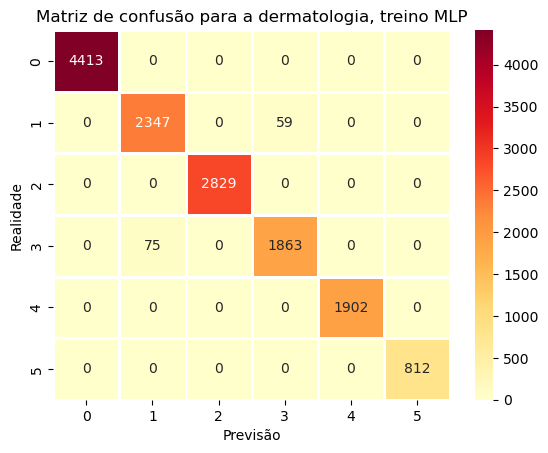

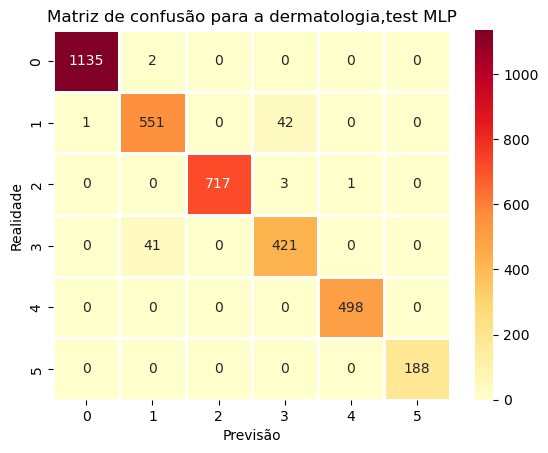

In [23]:
# dermatologia
dermatologia = pd.read_csv("dermatology/dermatology.data", header=None, sep=",")
dermatologia.rename(columns={34: "target"})
dermatologia.rename(columns={34: "target"}, inplace=True)
dermatologia = normaliza(dermatologia)
X2 = dermatologia.drop(["target"], axis=1)
y2 = dermatologia["target"] - 1


mlp3 = MLP(
    num_entrada=34,
    num_neuronio_oculto=20,
    num_classe=6,
    taxa_aprendizado=0.01,
    epocas=500,
)
(
    acuracias,
    std_acuracias,
    matrizes_confusao,
    erros_quadraticos,
    acuracias_t,
    std_acuracias_t,
    matrizes_confusao_t,
    erros_quadraticos_t,
) = mlp3.rodar_independentes(X2, y2, n_rodadas=50)

# imprimir resultados das 10 rodadas
print("\n----------------treino-----------------\n")
# for i in range(len(acuracias_t)):
# print(f"Rodada {i+1}: Acurácia = {(acuracias_t[i]*100):.2f}%, Erro Médio Quadrático = {erros_quadraticos_t[i]:.2f} , DP: {(std_acuracias_t[i]*100):.2f}%")
print(
    f"Acurácia = {(np.mean(acuracias_t)*100):.2f}%, Erro Médio Quadrático = {np.mean(erros_quadraticos_t):.2f} , DP: {(np.mean(std_acuracias_t)*100):.2f}%"
)
print(matrizes_confusao_t)

print("\n-----------------teste---------------\n")
# for i in range(len(acuracias)):
# print(f"Rodada {i+1}: Acurácia = {(acuracias[i]*100):.2f}%, Erro Médio Quadrático = {erros_quadraticos[i]:.2f} , DP: {(std_acuracias[i]*100):.2f}%")
print(
    f"Acurácia = {(np.mean(acuracias)*100):.2f}%, Erro Médio Quadrático = {np.mean(erros_quadraticos):.2f} , DP: {(np.mean(std_acuracias)*100):.2f}%"
)
print(
    matrizes_confusao
)  # Plotando a matriz de confusão usando a biblioteca seaborn para o caso 1

#       Class code:   Class:                  Number of instances:
#       0             psoriasis			              112
#       1             seboreic dermatitis             61
#       2             lichen planus                   72
#       3             pityriasis rosea                49
#       4             cronic dermatitis               52
#       5             pityriasis rubra pilaris        20
sns.heatmap(matrizes_confusao_t, annot=True, cmap="YlOrRd", linewidths=1, fmt=".0f")
# print(erros_quadraticos_t)
plt.title("Matriz de confusão para a dermatologia, treino MLP")
plt.xlabel("Previsão")
plt.ylabel("Realidade")
plt.show()

sns.heatmap(matrizes_confusao, annot=True, cmap="YlOrRd", linewidths=1, fmt=".0f")
plt.title("Matriz de confusão para a dermatologia,test MLP")
plt.xlabel("Previsão")
plt.ylabel("Realidade")
plt.show()
